In [1]:
# [CELL ID] 1

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Flatten, Linear, Sequential

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print('device:', device)

device: cuda:0


[CELL ID] 2
## Introduction

As we seek to deploy machine learning systems in the real world, it becomes critical that we examine not only whether the systems don't simply work "most of the time", but which are truly robust and reliable. Although many notions of robustness and reliability exist, one particular topic has raised a great deal of interest in recent years: robustness to adversarial examples. More precisely, can we develop classifiers that are robust to (test time) perturbations of their inputs, by an adversary intending to fool the classifier? 
A few years ago, researchers have shown that neural networks are vulnerable to <em> adversarial examples</em>, i.e. imperceptible variations of natural examples, crafted to deliberately mislead the models.

<img width="500" src="https://languagelog.ldc.upenn.edu/myl/adversarial-example.png">

The purpose of this project is to teach you how these pertubations are crafted and how can we create robust classifier. 

[1] Nightmare at test time: robust learning by feature deletion <br>
[2] Evasion attacks against machine learning at test time <br>
[3] Intriguing properties of neural networks

[CELL ID] 3
## Some introductory notation

Let us consider a model $h_\theta : \mathcal{X} \rightarrow \mathbb{R}^k$ mapping an input $x$, to a vector $h_\theta(x)$ in $\mathbb{R}^k$ (where $k$ is the number of classes being predicted). $h_\theta(x)$ is called a logit vector of the model $h_\theta$ where each coordinate can be positive or negative. The $\theta$ vector represents all the parameters defining this model (for example in a linear model it would represent the slope and the intercept). to get a prediction out of $h_\theta$ for a given $x$, the classical technique is to output the biggest coordinate of \begin{equation}
\DeclareMathOperator*{\argmax}{argmax}
\argmax_{j} h_\theta(x)_j 
\end{equation} where $h_\theta(x)_j$ denotes the $j$th elements of the vector $h_\theta(x)$.

In order the evaluate the quality of prediction of the model on a given example, we use a loss function $\ell: \mathbb{R}^k \times \mathbb{Z}_+ \rightarrow \mathbb{R}_+$ mapping the model predictions and true labels to a non-negative number. The semantics of this loss function are that the first argument is the model output (logits which can be positive or negative), and the second argument is the _index_ of the true class (that is, a number from 1 to $k$ denoting the index of the true label). Thus, the notation
\begin{equation}
\ell(h_\theta(x), y)
\end{equation}
for $x \in \mathcal{X}$ the input and $y \in \mathbb{Z}$ the true class, denotes the loss that the classifier achieves in its predictions on $x$, assuming the true class is $y$.  By far the most common form of loss used in machine learning (especially in deep learning) is the cross entropy loss (also sometimes called the softmax loss), defined as
\begin{equation}
\ell(h_\theta(x), y) = \log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right ) - h_\theta(x)_y
\end{equation}
where $h_\theta(x)_j$ denotes the $j$th elements of the vector $h_\theta(x)$.

Recall that a common approach to training a classifier is to optimize the _parameters_ $\theta$, so as to minimize the average loss over some training set $\{x_i \in \mathcal{X}, y_i \in \mathbb{Z}\}$, $i=1,\ldots,m$, which we write as the optimization problem
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{m} \sum_{i=1}^m \ell(h_\theta(x_i), y_i)
\end{equation}
which we typically solve by (stochastic) gradient descent.  I.e., for some minibatch $\mathcal{B} \subseteq \{1,\ldots,m\}$, we compute the gradient of our loss with respect to the parameters $\theta$, and make a small adjustment to $\theta$ in this negative direction
\begin{equation}
\theta := \theta - \frac{\alpha}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \nabla_\theta \ell(h_\theta(x_i), y_i)
\end{equation}
where $\alpha$ is some step size, and we repeat this process for different minibatches covering the entire training set, until the parameters convergence.

[CELL ID] 4
## Creating an adversarial example

To create an adversarial example, instead of adjusting the parameters $\theta$ with the gradient define above: $\nabla_\theta \ell(h_\theta(x_i), y_i)$, we are going to adjust the image in order to _maximize_ the loss. Therefore, we want to solve the optimization problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\hat{x}} \ell(h_\theta(\hat{x}), y)
\end{equation}
where $\hat{x}$ denotes our adversarial example that is attempting to maximize the loss.

Of course, we cannot just optimize arbitrarily over $\hat{x}$ (there do exist, after all, some images that are _not_ pandas, and if we change the image entirely, say to a dog, then it's not particularly impressive that we can "fool" the classifier into thinking it's not a panda). So we instead need to ensure that $\hat{x}$ is close to our original input $x$. By convention, we typically do this by optimizing over the _perturbation_ to $x$, which we will denote $\delta$
\begin{equation}
\maximize_{\delta \in \Delta} \ell(h_\theta(x +\delta), y)
\end{equation}
where $\Delta$ represents an allowable set of perturbations (typically perturbation that make $x + \tau$ sufficiently close to $x$).  

Characterizing the "correct" set of allowable perturbations is actually quite difficult: in theory, we would like $\Delta$ to capture anything that humans visually feel to be the "same" as the original input $x$.  This can include anthing ranging from adding slight amounts of noise, to rotating, translating, scaling, or performing some 3D transformation on the underlying model, or even completely changing the image in the "non-panda" locations.  Needless to say, it is not possible to give a mathematically rigorous definition of all the perturbations that _should_ be allowed, but the philosophy behind adversarial examples is that we can consider some _subset_ of the possible space of allowed perturbations, such that by any "reasonable" definition, the actual semantic content of the image could not change under this perturbation.

A common perturbation set to use, though by no means the only reasonable choice, is the $\ell_\infty$ ball, defined by the set
\begin{equation}
\Delta = \{\delta : \|\delta\|_\infty \leq \epsilon\}
\end{equation}
where the $\ell_\infty$ norm a vector $z$ is defined as
\begin{equation}
\|z\|_\infty = \max_i |z_i|
\end{equation}
i.e., we allow the perturbation to have magnitude between $[-\epsilon, \epsilon]$ in each of its components (it is a slightly more complex, as we also need to ensure that $x + \delta$ is also bounded between $[0,1]$ so that it is still a valid image).  

[CELL ID] 5
## Binary classification

Let's begin first by considering a simplified problem where $h_\theta$ is a linear classifier (see below) and k=2.  In this case called binary classification, rather than use multi-class cross entropy loss, we'll be adopting the more common approach and using the binary cross entropy, or logistic loss. In this setting, we have our hypothesis function
\begin{equation}
h_\theta(x) = w^T x + b
\end{equation}
for $\theta = \{w \in \mathbb{R}^n, b \in \mathbb{R}\}$, class label $y \in \{+1,-1\}$, and loss function
\begin{equation}
\ell(h_\theta(x), y) = \log(1+\exp(-y\cdot h_\theta(x))) \equiv L(y \cdot h_\theta(x))
\end{equation}
where for convience below we define the function $L(z) = \log(1+\exp(-z))$ which we will use below when discussing how to solve the optimization problems involving this loss.  The semantics of this setup are that for a data point $x$, the classifier predicts class $+1$ with probability
\begin{equation}
p(y=+1|x) = \frac{1}{1 + \exp(-h_\theta(x))}.
\end{equation}


[CELL ID] 6
### Computing an Adversarial pertubation

Let us consider the creation of an adversarial example in the context of binary classification:
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(w^T (x+\delta), y) \equiv \maximize_{\|\delta\| \leq \epsilon} L(y \cdot (w^T(x+\delta) + b)).
\end{equation}
The key point we need to make here is that in this setting, it is actually possible to solve this maximization problem exactly. 

Because the function is monotonic decreasing, if we want to maximize this function applied to a scalar, that is equivalent to just minimizing the scalar quantity.  That is
\begin{equation}
\begin{split}
\DeclareMathOperator*{\minimize}{minimize}
\max_{\|\delta\| \leq \epsilon} L \left(y \cdot (w^T(x+\delta) + b) \right) & =
L\left( \min_{\|\delta\| \leq \epsilon}  y \cdot (w^T(x+\delta) + b) \right) \\
& = L\left(y\cdot(w^Tx + b) + \min_{\|\delta\| \leq \epsilon} y \cdot w^T\delta  \right)
\end{split}
\end{equation}
where we get the second line by just distributing out the linear terms.

Thanks to this simplification of the initial problem, we only need to consider how to solve the problem
\begin{equation}
\min_{\|\delta\| \leq \epsilon} y \cdot w^T\delta.
\end{equation}
To get the intuition here, let's just consider the case that $y = +1$, and consider an $\ell_\infty$ norm constraint $\|\delta\|_\infty \leq \epsilon$.  Since the $\ell_\infty$ norm says that each element in $\delta$ must have magnitude less than or equal $\epsilon$, we clearly minimize this quantity when we set $\delta_i = -\epsilon$ for $w_i \geq 0$ and $\delta_i = \epsilon$ for $w_i < 0$.  For $y = -1$, we would just flip these quantities.  That is, the optimal solution to the above optimization problem for the $\ell_\infty$ norm is given by
\begin{equation}
\delta^\star = - y \epsilon \cdot \mathrm{sign}(w)
\end{equation}

### Exercice 1

Let's see what this looks like for an actual linear classifier.  In doing so, we can also get a sense of how well traditional linear models might work to also prevent adversarial examples.

1. Define and train with gradient descent a linear model using the PyTorch library a binarize version of the MNIST dataset
2. Evaluate your model on the train and test dataset 
3. Create adversarial pertubation on the images of the test set and evaluate the performance of your model <em>under attack</em>
4. Evaluate the visibility of the pertubation by ploting the natural image next to the adversarial image 
5. Make a small analysis and conclusion

### 1.1 Loading MNIST dataset (train set and test set)

Nous allons charger les données MNIST. Nous ne garderons que les données relatives aux 0 et 1. Dans ce cas d'étude nous allons nous étudier un classificateur binaire.

In [2]:
# [CELL ID] 7

# binary MNIST dataset
def load_binary_mnist(split, batch_size):
    train = (split == 'train')
    dataset = datasets.MNIST("./data", train=train, download=True, transform=transforms.ToTensor())
    idx = dataset.targets <= 1 # we select only images corresponding to 0 and 1
    dataset.data = dataset.data[idx]
    dataset.targets = dataset.targets[idx]
    return DataLoader(dataset, batch_size=batch_size, shuffle=train) # shuffle only the train dataset

batch_size = 100
train_loader = load_binary_mnist('train', batch_size)
test_loader = load_binary_mnist('test', batch_size)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 1.2 Creating Linear model
Nous allons implémenter un réseau linéaire assez simple  qui prend en entrée une image de taille 28x28 et produit en sortie un label 0 ou 1.

In [3]:
# [CELL ID] 8

# Define your model
class LinearModel(torch.nn.Module):  
    """    
        The input image of size 28x28 is flattened into a vector of size 784 before calling the linear model (flatten -> linear)
    """
    def __init__(self, input_dim):
        super(LinearModel, self).__init__()
        self.model = Sequential(Flatten(), Linear(input_dim, 1, bias=True))

    def forward(self, x):
        return self.model(x).view(-1) # resize the output to fit the target dimension (vector of scalars)
    
    def weight(self):
        """ Convenience function to get the linear model weight (w) used to compute the adverserial images """
        return self.model[1].weight 


**Utility fonction performing one epoch over a dataset**  
La fonction ci-dessous réalise l'entrainement du $model$ passé en paramètre sur un époque. Elle prend en paramètre la fonction de côut (_objective function_) et la fonction utilisée pour perturber éventuellement l'image (en cas d'attaque). 

In [4]:
# perform one complete pass over the dataset
def process_one_epoch(model, loss_func, optimizer=None, attack_func=None):
  def handle(loader):
    
    last_loss, accuracy, n = 0.0, 0.0, 0.0

    for features, labels in loader:
      features = features.to(device) # send the images to the appropriate device
      labels = labels.float().to(device) # send the labels to the appropriate device
      
      # if we are under attack, we apply some pertubation on the features
      if attack_func:
        features = attack_func(model, features, labels)

      outputs = model(features) # make a prediction
      loss = loss_func(outputs, labels) # compute the loss
        
      if optimizer:
        loss.backward() # compute the derivatives/gradient of the model parameters through the loss (PyTorch computation graph)
        optimizer.step() # update the model parameters with their corresponding gradient (computed above)
        optimizer.zero_grad() # initialize the model parameters gradient (cumulative by default)
      
      # compute the accuracy after comparing the predicted values to 0.
      # in fact, the probability corresponding to a single value (h(x)) should be >= 0.5 for the label y=+1
      # p(h(x)) = 1/(1+e(-h(x))) >= 1/2 -> e(-h(x)) <= 1 -> h(x) >= 0
      predictions = (outputs >= 0).float()
      accuracy += predictions.eq(labels).sum().item()
      last_loss += loss.item()
      n += labels.shape[0]

    return last_loss, accuracy/n

  return handle

### 1.3 Training the model on the train set

Nous allons entraîner une instance du modèle linéaire définie ci-dessus sur les données d'entraînement en utilisant la $BCEWithLogitsLoss$ pour le calcul du _loss_ et la $SGD$ pour l'optimisation.

In [5]:
# define the linear model with the images dimensions 28x28
linear_model = LinearModel(784).to(device)

# define your loss
loss_func = nn.BCEWithLogitsLoss(reduction='mean').to(device)

# define your optimizer SGD with learning rate 0.1
optimizer = optim.SGD(linear_model.parameters(), lr=0.1)

# define the training epoch-function (handler)
training_epoch_handler = process_one_epoch(model=linear_model, 
                                           loss_func=loss_func, 
                                           optimizer=optimizer)
# define number of epochs
epochs = 10

# we train our model (mini-batch)
print("epoch", "loss", "accuracy", sep="\t\t")
for epoch in range(epochs):
  loss, accuracy = training_epoch_handler(train_loader)
  print("{}\t\t{:.5f}\t\t{:.5f}".format(epoch, loss, accuracy))

epoch		loss		accuracy
0		7.06489		0.99155
1		1.98862		0.99763
2		1.47793		0.99771
3		1.23906		0.99787
4		1.09763		0.99803
5		0.99770		0.99826
6		0.92439		0.99842
7		0.86698		0.99866
8		0.82145		0.99866
9		0.78255		0.99866


### 1.4 Evaluating the model ...

La fonction ci-dessous permet d'évaluer un modèle entraîné sur les données passées en paramètre ($loader$).

In [6]:
# [CELL ID] 9

# define the testing epoch-function (handler)
testing_epoch_handler = process_one_epoch(model=linear_model, loss_func=loss_func)

def evaluate_model(loader):
  result = []
  # evalutation on the test set
  for epoch in range(epochs):
    result.append(testing_epoch_handler(loader))

  loss = sum([l[0] for l in result])/epochs
  accuracy = sum([l[1] for l in result])/epochs

  print("loss", "accuracy", sep="\t\t")
  print("{:.5f}\t\t{:.5f}".format(loss, accuracy))

 ### ... On the train set
 Evaluation sur les données d'entraînement.

In [7]:
evaluate_model(train_loader)

loss		accuracy
0.76082		0.99874


### ... On the test set
Evaluation sur les données de test.

In [8]:
# [CELL ID] 9
evaluate_model(test_loader)


loss		accuracy
0.07852		0.99953


Les précisions (accuracy) obtenus dans les deux cas sont assez proches: le modèle n'overfit pas.

### 1.5 Generating the adverserial perturbation

Espilon consitue un hyperparamètre de notre analyse. Nous allons étudier son impact sur les attaques et pour ce faire nous allons utilise plusieurs esplions.

perturbation images for different levels of epsilon:


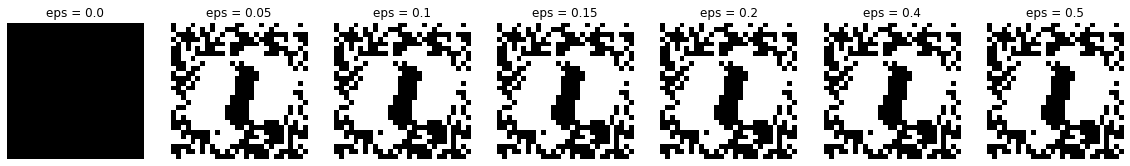

In [9]:
# [CELL ID] 10
# utility function to display an image
def display_perturbation(img, ax, pos, eps):
  ax[pos].imshow(img.view(28, 28).numpy(), cmap="gray")
  ax[pos].axis('off')
  ax[pos].set_title('eps = ' + str(eps))

# set the hyperpermater episilon for our analysis. For comparison purpose, we add 0 to the list
epsilons = [0., 0.05, 0.1, 0.15, 0.2, 0.4, 0.5] # we set epsilon values

print('perturbation images for different levels of epsilon:')
_, ax = plt.subplots(1, len(epsilons))
plt.gcf().set_size_inches(20, 20)

for i, epsilon in enumerate(epsilons):
  delta = epsilon * linear_model.weight().detach().cpu().sign() # we compute the delta
  display_perturbation(0 - delta.reshape(28, 28), ax, i, epsilon)

Ci-dessous les images des pertubations obtenues pour chacune des valeurs d'epslion.  
Visuellement, les images se ressemblent à cause de l'effet de seuil à l'affichage. En effet les valeurs de pixels supérieures à 1 sont ramenées à 1 et celles inférieurs à 0 sont ramenées à 0. En revanche l'impact sera visible numériquement lors de l'attaque.  

### 1.6 Applying the perturbation on the test set

We apply here the perturbations above on the test set images and evaluate the model accuracy.

epsilon		loss		accuracy
0.00000		0.079		0.999527
0.05000		0.450		0.996217
0.10000		2.314		0.977305
0.15000		9.729		0.810402
0.20000		29.260		0.375887
0.40000		193.401		0.000000
0.50000		285.633		0.000000




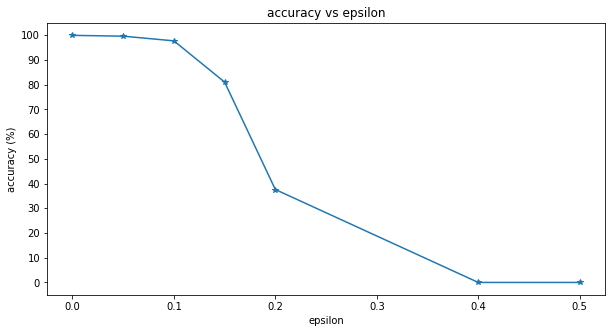

In [10]:
# [CELL ID] 11

# compute the perturbation (delta) and add it to the original image
def attack_image(epsilon):
  """ Compute the perturbation (delta) and apply it to the img if supplied  """
  def handle(model, imgs, labels):
    delta = epsilon * model.weight().detach().cpu().sign().to(device)
    return imgs.view(-1, 784) - delta * (2 * labels.float().view(-1, 1) - 1)
  return handle


# display the eps vs accuracy curve
def plot_eps_accuracy(epsilons, accuracies):
  accuracies = [100*c for c in accuracies]
  plt.figure(figsize=(10, 5))
  plt.plot(epsilons, accuracies, "*-")
  plt.xticks(np.arange(0, 0.6, step=0.1))
  plt.yticks(np.arange(0, 101, step=10))
  plt.title("accuracy vs epsilon")
  plt.xlabel("epsilon")
  plt.ylabel("accuracy (%)")
  plt.show()


accuracies = []
print('epsilon', 'loss', 'accuracy', sep='\t\t')

# for each epsilon, we compute the attacked image and evalute the model on it
for epsilon in epsilons:
  # we define the adverserial attack function
  attack_func = attack_image(epsilon)

  # then we define the testing attack epoch-function (handler)
  adverse_testing_epoch_handler = process_one_epoch(model=linear_model, 
                                            loss_func=loss_func, 
                                            optimizer=None,
                                            attack_func=attack_func)

  # we evaluate the model on the test set under attack
  avg_loss, avg_accuracy = 0.0, 0.0
  for epoch in range(epochs):
    loss, accuracy = adverse_testing_epoch_handler(test_loader)
    avg_loss += loss
    avg_accuracy += accuracy

  acc = avg_accuracy/epochs
  loss = avg_loss/epochs
  accuracies.append(acc)

  print('{:.5f}'.format(epsilon), '{:.3f}'.format(loss), '{:.6f}'.format(acc), sep='\t\t')

print('\n')
plot_eps_accuracy(epsilons, accuracies)

Le graphique ci-dessus montre que le modèle arrive encore à prédire correctement pour les valeurs d'$epsilon$ faibles (<= 0.15) et échoue à partir de 0.2.

### 1.7 Evaluating the visibility of the perturbation

Nous allons analyser l'aspect visuel des images perturbées et la prédiction réalisée par le modèle pour chacune des valeurs de $epsilon$.

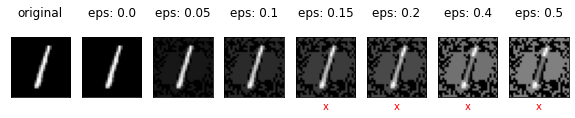

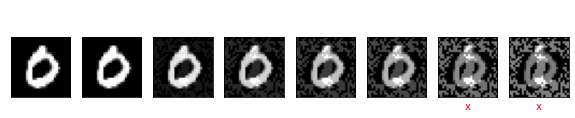

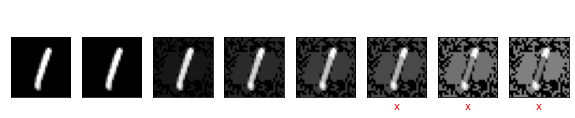

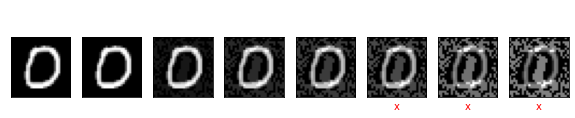

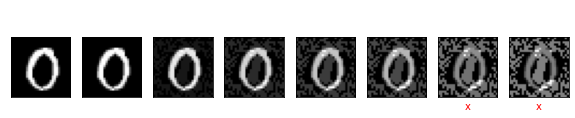

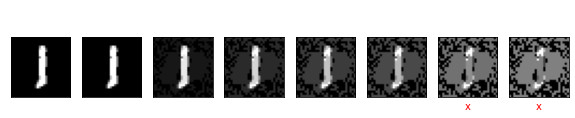

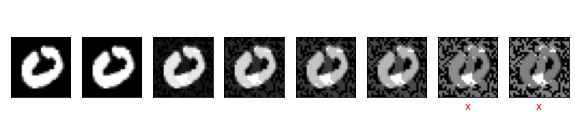

In [11]:
# utility function to display images (original, perturbation, adversarial)
def display_image(img, ax, title='', lg='', color='g'):
    ax.imshow(img.view(28, 28), cmap='gray')
    ax.set_title(lg + '\n')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(title)
    ax.xaxis.label.set_color(color)
    ax.tick_params(color=color)


# we load first mini-batch of the test set
imgs, labels = next(iter(test_loader))

# we iterate through the 7-th images
for i in range(7):  
  img = imgs[i].to(device)
  label = labels[i].to(device)
  
  _, ax = plt.subplots(1, len(epsilons) + 1, sharey=True)
  plt.gcf().set_size_inches(10, 10)
  
  lg = f'original' if i == 0 else ''
  display_image(imgs[i], ax[0], '', lg=lg, color='black')

  for j, epsilon in enumerate(epsilons):
    attack_func = attack_image(epsilon)
    adv_img = attack_func(linear_model, img, label)
    pred = (linear_model(adv_img) >= 0).int().item()

    lg = f'eps: {epsilon}' if i == 0 else f''
    title = '' if pred == label else 'x'
    color = 'g' if pred == label else 'r'
    display_image(adv_img.detach().cpu(), ax[j+1], title=title, lg=lg, color=color)
  

### Conclusion :  
La planche ci-dessus montre bien l'influence de `epsilon` sur l'aspect visuel des images et les prédictions réalisées. Plus `epsilon` est grand plus l'image se dégrade (attaque grossière) et plus le modèle prédit mal.  

Avec un `epsilon<=0.15` les images sont visuellement à peine modifiées. Le modèle s'en sort bien avec une précision de 97%  

En revanche, avec `epsilon=0.2`, les images perturbées restent visuellement identifiables avec un niveau de gris modifié. En effet les chiffres sont reconnaissables et comportent des "taches" grises.  
L'évaluation du modèle réalisée sur les images du jeu de test attaquées (pertubées) dans ces conditions (`eps=0.2`) a donné une précision de 40%.  

La précision tombe à 0 pour `epsilon>=0.4`. On peut comprendre l'incapacité du modèle à prédire correctement les chiffres car visuellement le contraste des images perturbées est radicalement éloigné de celui des images originales même si l'on arrive encore à distinguer les chiffres.

En conclusion, par défaut, la combinaison d'un modèle linéaire avec la norme infinie sur la perturbation n'est pas assez robuste pour répondre aux attaques. Le classifieur peut donc être facilement trompé là où l'oeil humain s'en sort encore.